In [ ]:
%pip install tensorflow


In [ ]:
!pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [4]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [5]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS , 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
draw_landmarks(frame, results)

In [ ]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [ ]:
len(results.face_landmarks.landmark)

In [7]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

NameError: name 'results' is not defined

In [6]:
def extract_keypoints(res):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh]) 

In [ ]:
result_test = extract_keypoints(results)
result_test.shape

In [ ]:
np.save('0', result_test)

In [ ]:
np.load('0.npy')

In [8]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['A', 'makan', 'kenapa', 'bermain'])

# Thirty videos worth of data
no_sequences = 30

# Videos are going to be 30 frames in length
sequence_length = 30

# Folder start
start_folder = 30

In [9]:
for action in actions:
    for sequence in range(no_sequences):
        try:
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

In [ ]:
'''
for action in actions: 
    dirmax = np.max(np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int))
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(dirmax+sequence)))
        except:
            pass
'''

In [ ]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
#                 print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(5000) # <--- Ini adalah timer sleep yang mengatur delay 2000 ms (2 detik)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

In [10]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [11]:
label_map = {label:num for num, label in enumerate(actions)}

In [12]:
label_map

{'A': 0, 'makan': 1, 'kenapa': 2, 'bermain': 3}

In [13]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [14]:
X = np.array(sequences)

In [15]:
y = to_categorical(labels).astype(int)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)
y_test.shape

(6, 4)

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [18]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [19]:
'''
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))
'''
model = Sequential()
model.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(30, X.shape[2])))
model.add(LSTM(256, return_sequences=True, activation='relu'))
model.add(LSTM(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

C:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │         916,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,525,380 (5.82 MB)

 Trainable params: 1,525,380 (5.82 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [31]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 213ms/step - categorical_accuracy: 0.3149 - loss: 37.3803
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - categorical_accuracy: 0.2577 - loss: 22.4894
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - categorical_accuracy: 0.2548 - loss: 55.5248
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - categorical_accuracy: 0.2684 - loss: 56.8106
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - categorical_accuracy: 0.2952 - loss: 105.0019
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - categorical_accuracy: 0.2581 - loss: 73.4640
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step - categorical_accuracy: 0.2152 - loss: 158.5265
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - categorical_accuracy: 0.2821 - loss: 118.3812
Epoch 9/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - categorical_accuracy: 0.2057 - loss: 135.1896
Epoch 10/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - categorical_accuracy: 0.1817 - loss: 136.1187
Epoch 11/500
4

In [32]:
res = model.predict(X_test)
res

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


array([[9.8564523e-01, 2.3840413e-04, 1.9412148e-07, 1.4116157e-02],
       [9.9900073e-01, 3.7937120e-06, 1.8823509e-09, 9.9551550e-04],
       [5.1720285e-01, 5.3613946e-02, 2.5106088e-04, 4.2893210e-01],
       [3.5945550e-02, 3.2018194e-01, 5.8436364e-01, 5.9508782e-02],
       [9.5680064e-01, 1.3066325e-03, 1.1579992e-06, 4.1891545e-02],
       [7.7006511e-02, 5.9751058e-01, 3.4617297e-02, 2.9086560e-01]],
      dtype=float32)

In [33]:
actions[np.argmax(res[0])]

'A'

In [34]:
actions[np.argmax(y_test[0])]

'A'

In [40]:
model.save('action.h5')

In [ ]:
del model

In [41]:
model.load_weights('action.h5')

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score


In [35]:
yhat = model.predict(X_test)
yhat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


array([[9.8564523e-01, 2.3840413e-04, 1.9412148e-07, 1.4116157e-02],
       [9.9900073e-01, 3.7937120e-06, 1.8823509e-09, 9.9551550e-04],
       [5.1720285e-01, 5.3613946e-02, 2.5106088e-04, 4.2893210e-01],
       [3.5945550e-02, 3.2018194e-01, 5.8436364e-01, 5.9508782e-02],
       [9.5680064e-01, 1.3066325e-03, 1.1579992e-06, 4.1891545e-02],
       [7.7006511e-02, 5.9751058e-01, 3.4617297e-02, 2.9086560e-01]],
      dtype=float32)

In [36]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [37]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[2, 1],
        [0, 3]],

       [[4, 0],
        [1, 1]],

       [[5, 1],
        [0, 0]],

       [[5, 0],
        [1, 0]]], dtype=int64)

In [42]:
accuracy_score(ytrue, yhat)


0.6666666666666666

In [39]:
colors = [(245,117,16), (117,245,16), (16,117,245), (255,255,153)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [56]:
# 1. New detection variables
sequence = []
sentence = []
threshold = 0.2

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
#        sequence.insert(0,keypoints)
#        sequence = sequence[:30]

        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            
            
        #3. Viz logic
            if res[np.argmax(res)] > threshold: 
                if len(sentence) > 0: 
                    if actions[np.argmax(res)] != sentence[-1]:
                        sentence.append(actions[np.argmax(res)])
                else:
                    sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

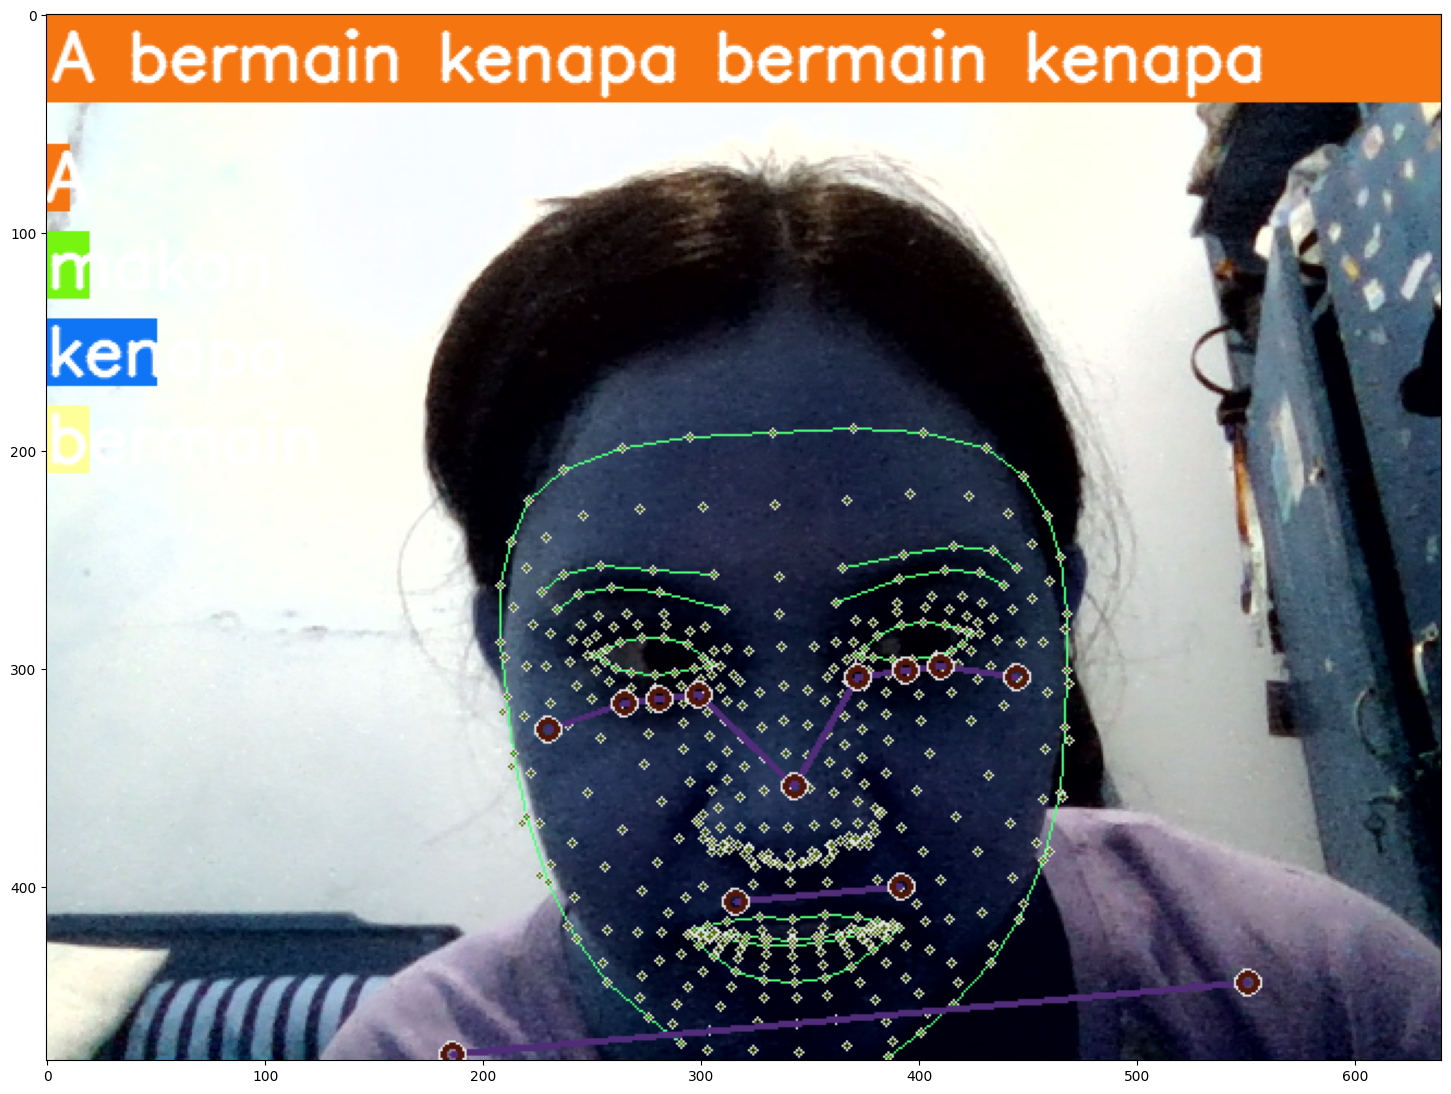

In [44]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

In [45]:
len(sequence)


30

In [46]:
sequence.append('def')


In [47]:
sequence.reverse()


In [48]:
sequence[-30:]


[array([ 0.53650141,  0.73893857, -1.75065386, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53235823,  0.74162775, -1.74622881, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.53385895,  0.74662787, -1.66996193, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.55885607,  0.74780393, -2.01485944, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.59649742,  0.73284233, -1.99767172, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.5981887 ,  0.71983057, -2.06236696, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.59941888,  0.69371432, -2.43120408, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60214126,  0.66786414, -1.9225359 , ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.60544503,  0.66661429, -1.49076772, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.61256284,  0.66606456, -1.44701231, ...,  0.        ,
         0.        ,  0.  

In [49]:
cap.release()
cv2.destroyAllWindows()

In [50]:
res[np.argmax(res)] > threshold


True

In [51]:
(num_sequences,30,1662)


NameError: name 'num_sequences' is not defined

In [52]:
model.predict(np.expand_dims(X_test[0], axis=0))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


array([[9.8564523e-01, 2.3840276e-04, 1.9412074e-07, 1.4116123e-02]],
      dtype=float32)